# Complete analysis for Experiment 1

In [1]:
rm(list=ls())

In [131]:
library(dplyr)
library(ggplot2)
library(lme4)
library(lmerTest)
library(stringr)
library(car)

## Loading data

In [25]:
data.folder <- 'Experiment 1.'
file.list <- list.files(path= data.folder, pattern= 'csv$')
reports <- data.frame()
for(current.filename in file.list){
    current.observer <- read.csv2(file.path(paste(data.folder, current.filename, sep='/')))
    
    # extracting disambiguation method from 
    current.observer$disambiguation.method <- str_extract(current.filename, 'perspective|stereo')
    
    # discarding mixed phases
    current.observer <- current.observer[-which(current.observer$Percept=='unclear'), ]
    
    # splitting Unambiguous and Percept columns into one-column-per-object
    current.observer$unambiguous.L <- FALSE
    current.observer$unambiguous.L[current.observer$Unambiguious=='left'] <- TRUE
    current.observer$unambiguous.R <- FALSE
    current.observer$unambiguous.R[current.observer$Unambiguious=='right'] <- TRUE
    current.observer$ambiguity <- 'one'
    current.observer$ambiguity[current.observer$Unambiguious=='neither'] <- 'both'   
    
    # rotation of the left object
    current.observer$rotation.L <- 0 # unclear
    current.observer$rotation.L[current.observer$Percept %in% c('left', 'down')] <- -1
    current.observer$rotation.L[current.observer$Percept %in% c('right', 'up')] <- 1

    # rotation of the right object
    current.observer$rotation.R <- 0 # unclear
    current.observer$rotation.R[current.observer$Percept %in% c('left', 'up')] <- -1                              
    current.observer$rotation.R[current.observer$Percept %in% c('right', 'down')] <- 1                              

    # counter.rotation
    current.observer$counter.rotation <- NA
    current.observer$counter.rotation[current.observer$Percept %in% c('left', 'right')] <- FALSE
    current.observer$counter.rotation[current.observer$Percept %in% c('up', 'down')] <- TRUE
    
    # prettifying shape labels
    current.observer$Shape <- gsub('-0500', '', current.observer$Shape)
    
    # merging
    reports <- rbind(reports, current.observer)
}

# Computing duration of individual reports
reports <- reports %>%
    dplyr::group_by(Observer, Block) %>%
    dplyr::mutate(Duration= c(diff(Time), NA))

# bias direction label
reports$Direction.label <- ifelse(reports$Direction==-1, 'left', 'right')

# converting strings to factors
reports$ambiguity <- as.factor(reports$ambiguity)

## Computing demographics info, reported in the _Methods_ section

In [59]:
participants <- data.frame(Observer= unique(reports$Observer))
demographics <- participants %>%
    mutate(Observer= str_replace(Observer, '(R|r)$', ''), # removing trailing R, which is present for some participants
           gender= ifelse(str_detect(Observer, '(W|w)$'), 'female', 'male'),
           birth.year= as.numeric(str_extract(Observer, '\\d{2,4}')),
           birth.year= ifelse(birth.year<100, birth.year+1900, birth.year),
           age= 2017-birth.year) %>%

    group_by(gender) %>%
    summarise(count= n(), 
              min.age= min(age),
              max.age= max(age))

demographics

gender,count,min.age,max.age
female,12,19,36
male,5,21,29


## Effectiveness of disambiguation cues
Figure 2A in the manuscript

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-168.0538,-160.1789,87.02692,-174.0538,NA,NA,NA
lm.gap,4,-168.3428,-157.8429,88.17142,-176.3428,2.289001,1,0.13029372
lm.shape,5,-167.3838,-154.2590,88.69191,-177.3838,1.040983,1,0.30759302
lm.method,6,-168.6568,-152.9069,90.32839,-180.6568,3.272951,1,0.07043082


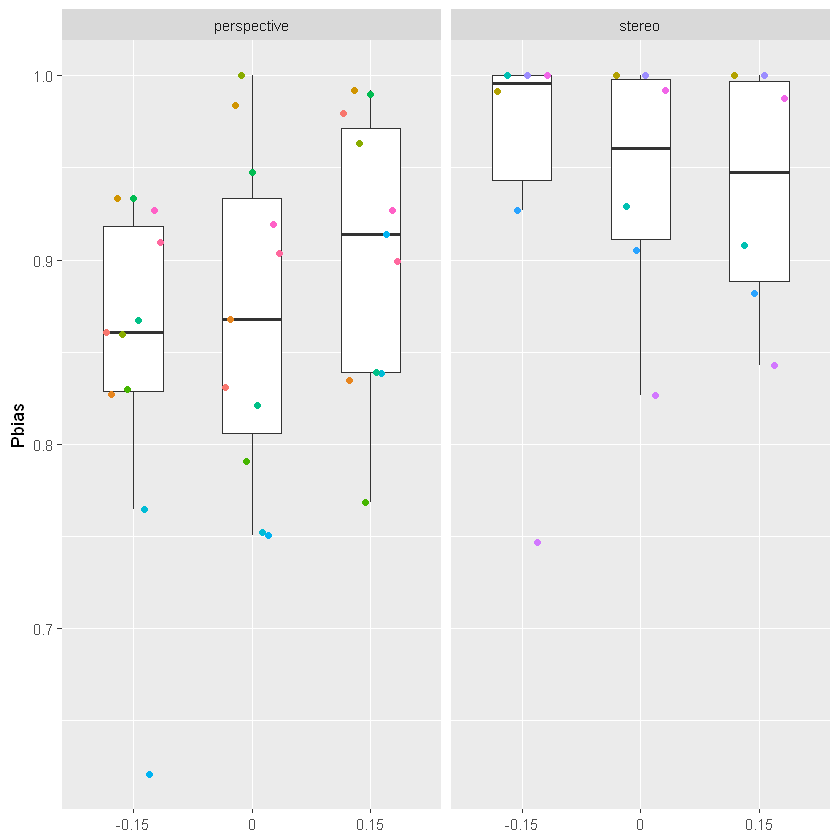

In [90]:
# disambiguation effect for each observer and gap x shape condition
disambiguation <- reports %>%
    dplyr::filter(Unambiguious != 'neither') %>% # considering only blocks with disambiguation cues
    dplyr::mutate(biased.object.percept= ifelse(Unambiguious=='left', rotation.L, rotation.R)) %>% # selecting disambiguated object
    dplyr::filter(is.finite(counter.rotation)) %>%
    dplyr::group_by(Observer, Block, Gap, Shape, disambiguation.method) %>% # computing fraction of time observers reported that congruent percept in each block
    dplyr::summarize(biased.fraction= sum(Duration[Direction == biased.object.percept])/sum(Duration)) %>%
    dplyr::group_by(Observer, Gap, Shape, disambiguation.method) %>%
    dplyr::summarize(biased.fraction= mean(biased.fraction))

# looking at the effect of condition on disambiguation cues effectiveness
lm.null <- lme4::lmer(biased.fraction ~ 1 + (1|Observer), data= disambiguation, REML= FALSE)
lm.gap <- update(lm.null, .~. + Gap)
lm.shape <- update(lm.gap, .~. + Shape)
lm.method <- update(lm.shape, .~. + disambiguation.method)
anova(lm.null, lm.shape, lm.gap, lm.method)

disambiguation <- disambiguation %>%
    dplyr::group_by(Observer, Gap, disambiguation.method) %>%
    dplyr::summarize(biased.fraction= mean(biased.fraction))

# plotting disambiguation effect per condition (gap x shape)
disambiguation.plot <- ggplot(data= disambiguation, 
                              aes(x= interaction(Gap), y= biased.fraction))+
    geom_boxplot(outlier.shape =  NA, width= 0.5 )+
    geom_point(aes(color= Observer), position= position_dodge(width= 0.5))+
    ylab('Pbias')+
    facet_grid(. ~ disambiguation.method)+
    theme(legend.position="none", axis.title.x=element_blank())
print(disambiguation.plot)
ggsave('Figures/Exp1 - disambiguation.pdf', disambiguation.plot, width= 8, height= 6, units = 'cm', useDingbats = FALSE)

## Computing fraction of time observers perceived _counter-rotation_ 

In [145]:
# computing fraction of time observers reported counter-rotation throughout each block
counter.rotation <- reports %>%
    dplyr::filter(is.finite(counter.rotation)) %>%
    dplyr::group_by(Observer, Block, Shape, Gap, ambiguity, disambiguation.method) %>%
    dplyr::summarize(fraction= sum(Duration[counter.rotation])/sum(Duration)) %>%
    dplyr::group_by(Observer, Shape, Gap, ambiguity, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# converting everything to factors for analysis
counter.rotation <- data.frame(counter.rotation)
counter.rotation$Gap <- as.factor(counter.rotation$Gap)
counter.rotation$ambiguity <- as.factor(counter.rotation$ambiguity)
counter.rotation$Shape <- as.factor(counter.rotation$Shape)
counter.rotation$disambiguation.method <- as.factor(counter.rotation$disambiguation.method)

# same by using multilevel apporach via linear-mixed models
lm.null <- lme4::lmer(fraction ~ 1 + (1|Observer), data= counter.rotation, REML= FALSE)
lm.gap <- update(lm.null, .~.+Gap)
lm.shape <- update(lm.gap, .~.+Shape)
lm.ambiguity <- update(lm.shape, .~.+ambiguity)
lm.disambiguation <- update(lm.ambiguity, .~. + disambiguation.method)
lm.shape.layout <- update(lm.disambiguation, .~. + Shape*Gap)
anova(lm.null, lm.shape, lm.gap, lm.ambiguity, lm.disambiguation, lm.shape.layout)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-18.05446,-8.100098,12.02723,-24.05446,NA,NA,NA
lm.gap,5,-40.04029,-23.449690,25.02014,-50.04029,25.9858315,2,2.276399e-06
lm.shape,6,-45.11582,-25.207103,28.55791,-57.11582,7.0755334,1,7.814356e-03
lm.ambiguity,7,-66.41777,-43.190931,40.20889,-80.41777,23.3019479,1,1.384597e-06
lm.disambiguation,8,-64.91518,-38.370223,40.45759,-80.91518,0.4974115,1,4.806397e-01
lm.shape.layout,10,-65.25840,-32.077199,42.62920,-85.25840,4.3432160,2,1.139942e-01


## Plotting all conditions  together for a birds-eye view
Figure 2B in the manuscript

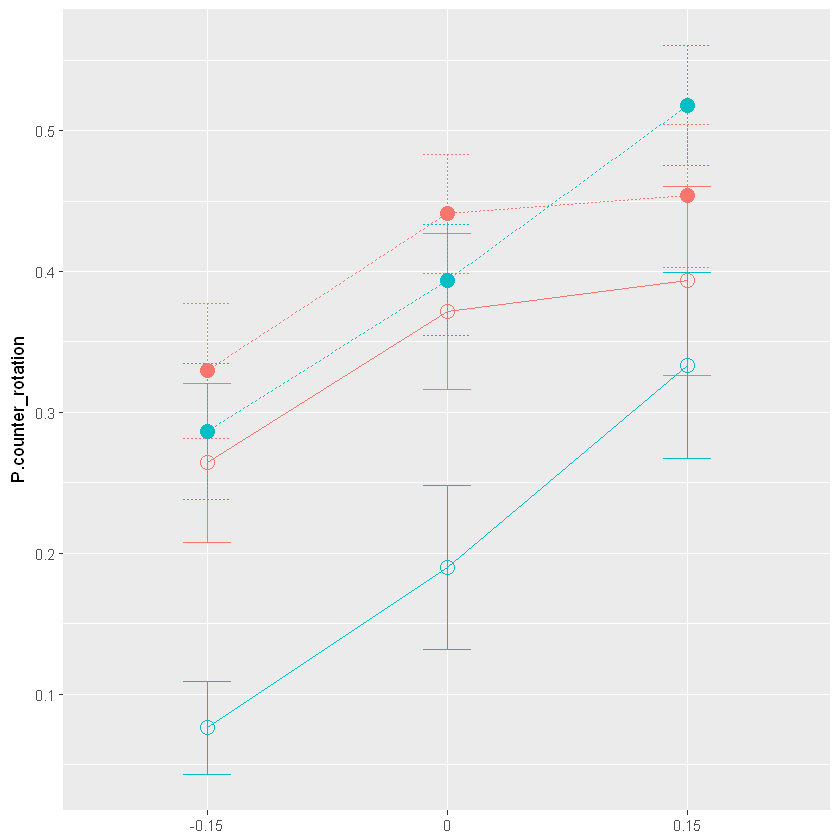

In [95]:
overall.averages <- counter.rotation %>%
    dplyr::group_by(Shape, Gap, ambiguity) %>%
    dplyr::summarise(P.counter_rotation= mean(fraction), 
                     P.serr= sd(fraction)/sqrt(n()-1), 
                     P.25=  quantile(fraction)[2],
                     P.75= quantile(fraction)[4])

overall.plot <- ggplot(data= overall.averages, aes(x= Gap, y= P.counter_rotation,
                                                  ymin= P.counter_rotation-P.serr, ymax= P.counter_rotation + P.serr,
                                                  group= interaction(Shape, ambiguity), color= Shape, shape= ambiguity,
                                                  linetype = ambiguity)) + 
    geom_line() + 
    geom_errorbar(width=0.2) + 
    geom_point(size= 4)+
    theme(legend.position="none", axis.title.x=element_blank())+
    xlab('Pcounter-rotation')+
    scale_shape_manual(values = c(1, 16))


print(overall.plot)
ggsave('Figures/Exp1 - overall.pdf', overall.plot, width= 6, height= 6.5, units = 'cm', useDingbats = FALSE)

## Plotting main effect of the gap
Figure 2C

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: fraction ~ Gap + (1 | Observer)
   Data: counter.rotation

REML criterion at convergence: -34.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.36887 -0.73081 -0.03676  0.70952  2.88215 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.005957 0.07718 
 Residual             0.042850 0.20700 
Number of obs: 204, groups:  Observer, 17

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.23913    0.03131  46.70000   7.636 9.29e-10 ***
Gap0          0.10995    0.03550 185.00000   3.097  0.00226 ** 
Gap0.15       0.18537    0.03550 185.00000   5.222 4.74e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
        (Intr) Gap0  
Gap0    -0.567       
Gap0.15 -0.567  0.500

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.2391291,0.03131409,46.70485,7.636471,9.285250e-10,0.7451704
0.1099462,0.03550060,185.00009,3.097023,2.259193e-03,0.2220150
0.1853681,0.03550060,185.00009,5.221548,4.743265e-07,0.3583937


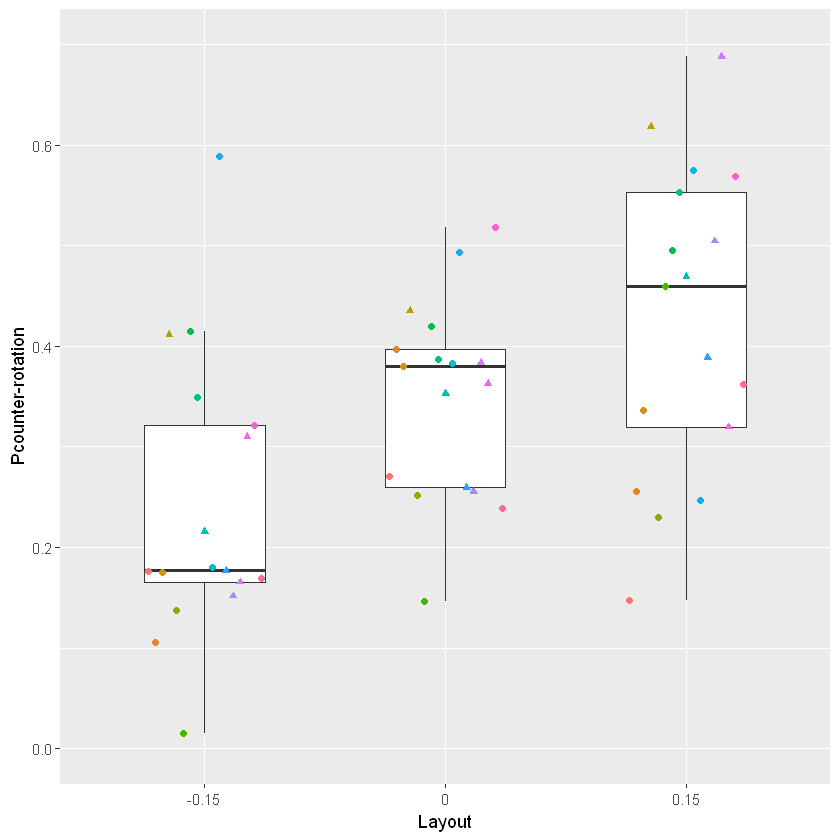

In [116]:
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

gap.df <- counter.rotation %>%
    dplyr::group_by(Observer, Gap, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# using gap as the only factor in LMER
gap.as.only.factor <- lmerTest::lmer(fraction ~ Gap + (1|Observer), data= counter.rotation)
summary(gap.as.only.factor)
coefficients.only <- data.frame(summary(gap.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

gap.plot <- ggplot(data= gap.df, aes(x= Gap, y= fraction))+
    geom_boxplot(outlier.shape =  NA, width= 0.5)+
    geom_point(aes(color= Observer, shape= disambiguation.method), , position= position_dodge(width= 0.5))+
    ylim(0, 0.7)+
    ylab('Pcounter-rotation')+
    xlab('Layout')+
    theme(legend.position="none")
print(gap.plot)
ggsave('Figures/Exp1 - main effect of gap.pdf', gap.plot, width= 6, height= 6.5, units = 'cm',  useDingbats = FALSE)

## Plotting main effect of the ambiguity
Figure 2D

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: fraction ~ ambiguity + (1 | Observer)
   Data: counter.rotation

REML criterion at convergence: -32.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8222 -0.8023 -0.0684  0.6523  3.5657 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.005848 0.07647 
 Residual             0.044165 0.21016 
Number of obs: 204, groups:  Observer, 17

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    0.27136    0.02787  30.36000   9.735 7.53e-11 ***
ambiguityone   0.13242    0.02943 186.00000   4.500 1.20e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
ambiguityon -0.528

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.2713583,0.02787422,30.35848,9.735101,7.531087e-11,0.8702791
0.1324177,0.02942770,186.00009,4.499766,1.196642e-05,0.3133250


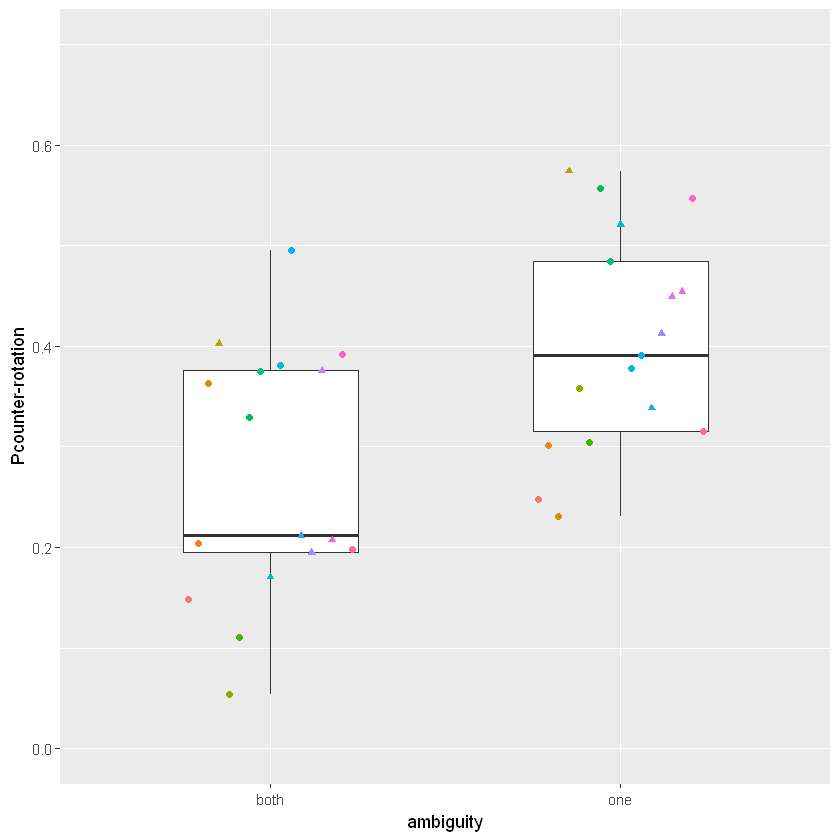

In [115]:
amb.df <- counter.rotation %>%
    dplyr::group_by(Observer, ambiguity, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# using ambiguity as the only factor in LMER
ambiguity.as.only.factor <- lmerTest::lmer(fraction ~ ambiguity + (1|Observer), data= counter.rotation)
summary(ambiguity.as.only.factor)
coefficients.only <- data.frame(summary(ambiguity.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

amb.plot <- ggplot(data= amb.df, aes(x= ambiguity, y= fraction))+
    geom_boxplot(outlier.shape = NA, width= 0.5)+
    geom_point(aes(color= Observer, shape= disambiguation.method), position = position_dodge(width= 0.5))+
    ylim(0, 0.7)+
    ylab('Pcounter-rotation')+
    theme(legend.position="none")
print(amb.plot)
ggsave('Figures/Exp1 - main effect of ambiguity.pdf', amb.plot, width= 4.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

## Plotting main effect of the shape
Figure 2E

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: fraction ~ Shape + (1 | Observer)
   Data: counter.rotation

REML criterion at convergence: -19.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0085 -0.8024  0.0078  0.6387  3.3082 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.005579 0.07469 
 Residual             0.047391 0.21769 
Number of obs: 204, groups:  Observer, 17

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.37555    0.02816  31.55000  13.338 1.64e-14 ***
Shapesphere  -0.07597    0.03048 186.00000  -2.492   0.0136 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
Shapesphere -0.541

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.37555200,0.02815640,31.54606,13.338070,1.643130e-14,0.9216216
-0.07596955,0.03048331,186.00008,-2.492169,1.357104e-02,0.1797581


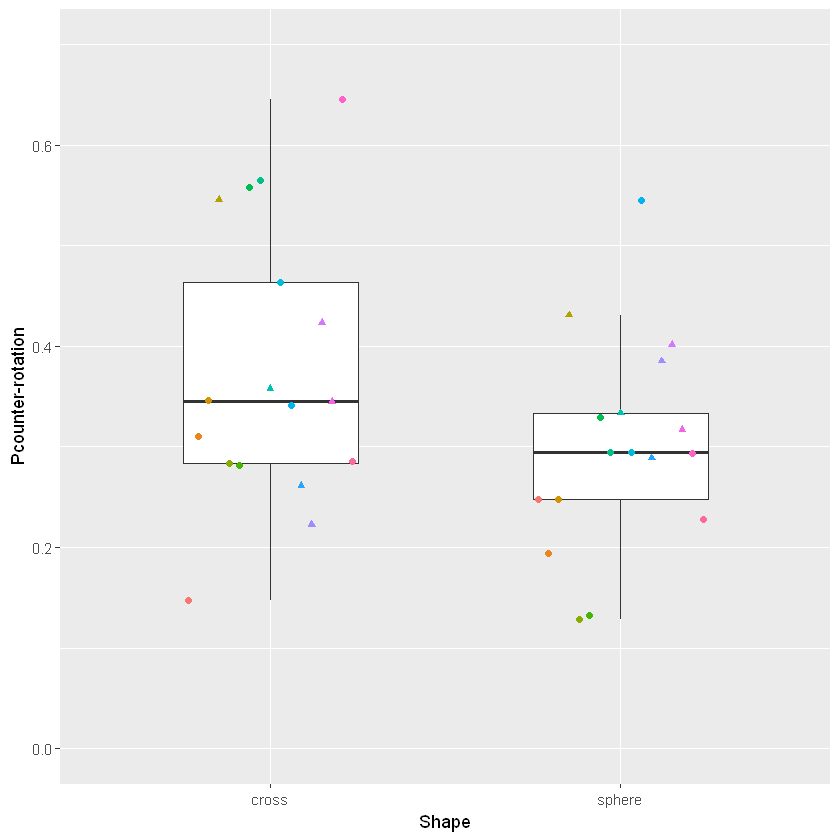

In [114]:
shape.df <- counter.rotation %>%
    dplyr::group_by(Observer, Shape, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# using shape as the only factor in LMER
shape.as.only.factor <- lmerTest::lmer(fraction ~ Shape + (1|Observer), data= counter.rotation)
summary(shape.as.only.factor)
coefficients.only <- data.frame(summary(shape.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


shape.plot <- ggplot(data= shape.df, aes(x= Shape, y= fraction))+
    geom_boxplot(outlier.shape = NA, width= 0.5)+
    geom_point(aes(color= Observer, shape= disambiguation.method), position = position_dodge(width= 0.5))+
    ylim(0, 0.7)+
    ylab('Pcounter-rotation')+
    theme(legend.position="none")
print(shape.plot)
ggsave('Figures/Exp1 - main effect of shape.pdf', shape.plot, width= 4.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

## Evaluating perceptual trapping
Figure 2F

First, counting eligible blocks

In [159]:
# computing fraction of time observers reported counter-rotation throughout each block
eligible.blocks <- reports %>%
    dplyr::filter(is.finite(counter.rotation)) %>%
    dplyr::group_by(Observer, disambiguation.method, Block, Shape, Gap, ambiguity) %>%
    dplyr::filter(n()>10) %>%
    dplyr::summarize(fraction= sum(Duration[counter.rotation])/sum(Duration, na.rm = TRUE))  %>%
    dplyr::filter(fraction>= 0.3 & fraction <= 0.7)
cat(sprintf('Number of eligible blocks: %d\n', nrow(eligible.blocks)))

eligible.participants <- eligible.blocks %>%
    group_by(Observer) %>%
    summarise()

cat(sprintf('Number of eligible participants: %d', nrow(eligible.participants)))


Number of eligible blocks: 87
Number of eligible participants: 11

In [176]:
persistence.relative.to.chance.level <- function(perceptual.reports){
    reports.N <- length(perceptual.reports)
    actual.persistence <- mean(perceptual.reports[1:(reports.N-1)]==perceptual.reports[2:reports.N])

    shuffle.repetitions <- 1000
    shuffled.persistence <- rep(NA, shuffle.repetitions) 
    for(iteration in 1:shuffle.repetitions){
        shuffled.reports <- sample(perceptual.reports)
        shuffled.persistence[iteration] <- mean(shuffled.reports[1:(reports.N-1)]==shuffled.reports[2:reports.N])
    }    

    # z-scoring the actual persistence based on the randomly sampled sequences
    z.scores <- c(scale(c(actual.persistence, shuffled.persistence)))
    return(z.scores[1])
    
    # computing there the actual persistence is relative to a distribution of randomly shuffled reports
    # we need to use -, as t-test measures distance from the center of distribution to the value and we need it the other way around
#     return(-t.test(logit(shuffled.persistence), mu= logit(actual.persistence))$statistic)
}

eligible.reports <- reports %>% 
    semi_join(eligible.blocks) %>%
    
    # adding unique block index
    group_by(Observer, disambiguation.method, Block, Shape, Gap, ambiguity) %>%
    mutate(block.id= str_c(as.character(Observer[1]), as.character(disambiguation.method[1]), as.character(Block[1]), as.character(Shape[1]), as.character(Gap[1]), as.character(ambiguity[1]))) %>%
    ungroup() %>%
    mutate(block.id= as.factor(block.id)) %>%
    
    # computing probability of perceptual trapping
    filter(is.finite(counter.rotation)) %>%
    group_by(Observer,block.id) %>%
    summarise(p.trapped= mean(counter.rotation[1:(n()-1)]==counter.rotation[2:n()]),
              z.trapped= persistence.relative.to.chance.level(counter.rotation)) 

Joining, by = c("Observer", "Block", "Shape", "Gap", "disambiguation.method", "ambiguity")


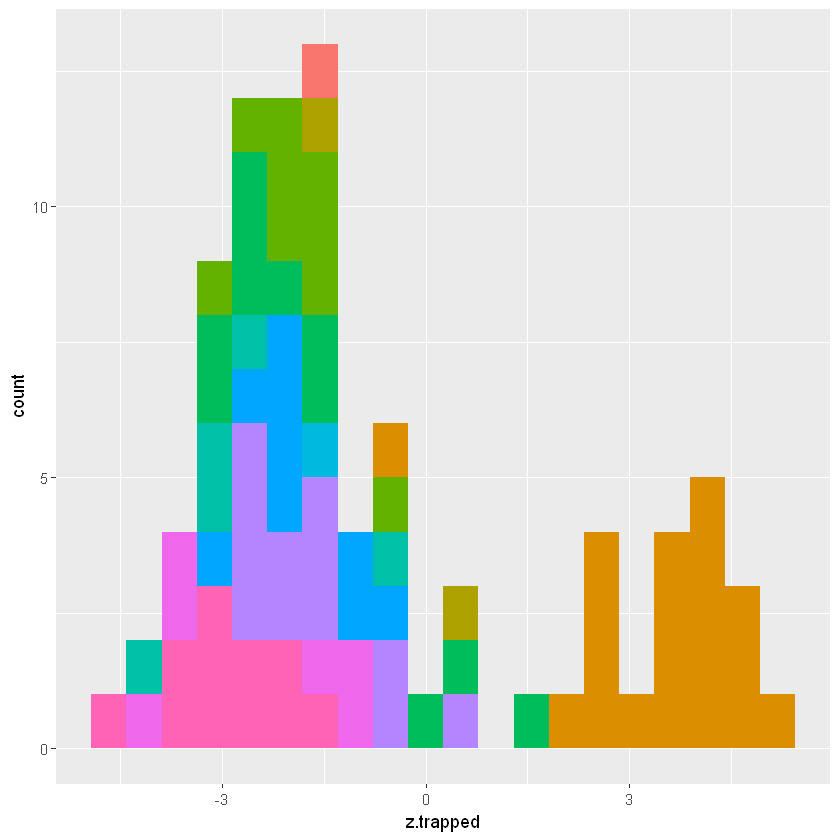

In [177]:
trapping.plot <- ggplot(data= eligible.reports, aes(x= z.trapped, fill= Observer)) + 
    geom_histogram(bins= 20)+
    theme(legend.position="none")
print(trapping.plot)
ggsave('Figures/Exp1 - perceptual trapping.pdf', trapping.plot, width= 8.5, height= 5.5, units = 'cm',  useDingbats = FALSE)